In [23]:
## Packages
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from tqdm import tqdm

In [ ]:
def load_data(data_dir: str, feature_range=(-1, 1)) -> dict:
    data_path = Path(data_dir)
    processed_data = {}

    # Find all parquet files
    parquet_files = list(data_path.glob("**/df*.parquet"))
    print(f"Found {len(parquet_files)} parquet files")

    for file_path in tqdm(parquet_files, desc="Processing cells", unit="cell"):
        # Extract cell number from parent directory name
        file_name = file_path.stem  
        cell_number = file_name.replace('df_', '')  
        cell_name = f'C{cell_number}'  
        tqdm.write(f"Processing {cell_name} ...")
            
        # Load and process data
        data = pd.read_parquet(file_path)
        data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        
        # Select relevant columns
        data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 
                    'Temperature[°C]', 'SOH_ZHU']]
        
        # Resample to hourly
        data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
        data_hourly = data.resample('h').mean().reset_index()
        
        # Fill missing values
        data_hourly.interpolate(method='linear', inplace=True)
        data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
        
        # Convert to time series
        target_series = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU'
        )
        covariates = TimeSeries.from_dataframe(
            data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 
            ['Current[A]', 'Voltage[V]', 'Temperature[°C]']
        )
        
        # Time align
        target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)
        
        # Scale covariates
        scaler = Scaler(scaler=MinMaxScaler(feature_range=(-1,1)))
        covariates_scaled = scaler.fit_transform(covariates)
        
        processed_data[cell_name] = {
            'target': target_series,
            'covariates_scaled': covariates_scaled
        }
    
    return processed_data

In [25]:
data_dir = "../01_Datenaufbereitung/Output/Calculated/"
processed_data = load_data(data_dir)

Found 15 parquet files


Processing cells:   0%|          | 0/15 [00:00<?, ?cell/s]

Processing C01 ...


Processing cells:   7%|▋         | 1/15 [00:09<02:19,  9.93s/cell]

Processing C03 ...


Processing cells:  13%|█▎        | 2/15 [00:15<01:38,  7.55s/cell]

Processing C05 ...


Processing cells:  20%|██        | 3/15 [00:21<01:22,  6.86s/cell]

Processing C07 ...


Processing cells:  27%|██▋       | 4/15 [00:27<01:11,  6.54s/cell]

Processing C09 ...


Processing cells:  33%|███▎      | 5/15 [00:31<00:54,  5.47s/cell]

Processing C11 ...


Processing cells:  40%|████      | 6/15 [00:35<00:44,  4.93s/cell]

Processing C13 ...


Processing cells:  47%|████▋     | 7/15 [00:37<00:32,  4.06s/cell]

Processing C15 ...


Processing cells:  53%|█████▎    | 8/15 [00:39<00:23,  3.39s/cell]

Processing C17 ...


Processing cells:  60%|██████    | 9/15 [00:45<00:25,  4.18s/cell]

Processing C19 ...


Processing cells:  67%|██████▋   | 10/15 [00:51<00:23,  4.74s/cell]

Processing C21 ...


Processing cells:  73%|███████▎  | 11/15 [00:57<00:20,  5.11s/cell]

Processing C23 ...


Processing cells:  80%|████████  | 12/15 [01:04<00:16,  5.65s/cell]

Processing C25 ...


Processing cells:  87%|████████▋ | 13/15 [01:08<00:10,  5.21s/cell]

Processing C27 ...


Processing cells:  93%|█████████▎| 14/15 [01:14<00:05,  5.33s/cell]

Processing C29 ...


Processing cells: 100%|██████████| 15/15 [01:18<00:00,  5.25s/cell]


In [26]:
def inspect_data_ranges(data_dict: dict):
   """
   Inspect time ranges and value ranges for each battery in the data dictionary
   """
   for cell_name, cell_data in data_dict.items():
       print(f"\n=== {cell_name} ===")
       
       # Get target data range
       target = cell_data['target']
       target_values = target.values().flatten()  # Flatten array for calculation
       print("\nTarget (SOH_ZHU):")
       print(f"Time Range: {target.start_time()} to {target.end_time()}")
       print(f"Value Range: {target_values.min():.4f} to {target_values.max():.4f}")
       print(f"Number of Data Points: {len(target)}")
       
       # Get covariates data range
       covariates = cell_data['covariates_scaled']
       cov_values = covariates.values()
       print("\nCovariates (scaled):")
       for i, feature in enumerate(covariates.components):
           values = cov_values[:, i].flatten()
           print(f"{feature}:")
           print(f"Value Range: {values.min():.4f} to {values.max():.4f}")

# View all data ranges
print("All Data Ranges:")
inspect_data_ranges(processed_data)

All Data Ranges:

=== C01 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-09-16 07:00:00
Value Range: 0.9225 to 1.0000
Number of Data Points: 5423

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C03 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-17 10:00:00
Value Range: 0.9206 to 1.0000
Number of Data Points: 4706

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C05 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 12:00:00
Value Range: 0.9172 to 1.0000
Number of Data Points: 4612

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C07 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 14

In [ ]:
def split_cell_data(processed_data: dict, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2) -> Tuple[Dict, Dict, Dict]:
   # Get all cell numbers
   cell_names = list(processed_data.keys())
   
   # Calculate number of cells needed for each set
   n_cells = len(cell_names)
   n_train = int(n_cells * train_ratio)
   n_val = int(n_cells * val_ratio)
   
   # Randomly shuffle cell order
   np.random.shuffle(cell_names)
   
   # Split cell numbers
   train_cells = cell_names[:n_train]
   val_cells = cell_names[n_train:n_train + n_val]
   test_cells = cell_names[n_train + n_val:]
   
   # Create dataset dictionaries
   train_data = {cell: processed_data[cell] for cell in train_cells}
   val_data = {cell: processed_data[cell] for cell in val_cells}
   test_data = {cell: processed_data[cell] for cell in test_cells}
   
   print(f"Data split completed:")
   print(f"Training set: {len(train_data)} cells {sorted(train_cells)}")
   print(f"Validation set: {len(val_data)} cells {sorted(val_cells)}")
   print(f"Test set: {len(test_data)} cells {sorted(test_cells)}")
   
   return train_data, val_data, test_data

# Usage example:
train_data, val_data, test_data = split_cell_data(processed_data)

Data split completed:
Training set: 9 cells ['C01', 'C05', 'C11', 'C15', 'C19', 'C21', 'C23', 'C25', 'C27']
Validation set: 3 cells ['C03', 'C07', 'C29']
Test set: 3 cells ['C09', 'C13', 'C17']


In [33]:
inspect_data_ranges(train_data)


=== C05 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-13 12:00:00
Value Range: 0.9172 to 1.0000
Number of Data Points: 4612

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C15 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 08:00:00 to 2023-04-11 15:00:00
Value Range: 0.6271 to 1.0000
Number of Data Points: 1640

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C27 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-08-01 09:00:00
Value Range: 0.9297 to 1.0000
Number of Data Points: 4321

Covariates (scaled):
Current[A]:
Value Range: -1.0000 to 1.0000
Voltage[V]:
Value Range: -1.0000 to 1.0000
Temperature[°C]:
Value Range: -1.0000 to 1.0000

=== C01 ===

Target (SOH_ZHU):
Time Range: 2023-02-02 09:00:00 to 2023-09-16 07:00:00
Value Rang

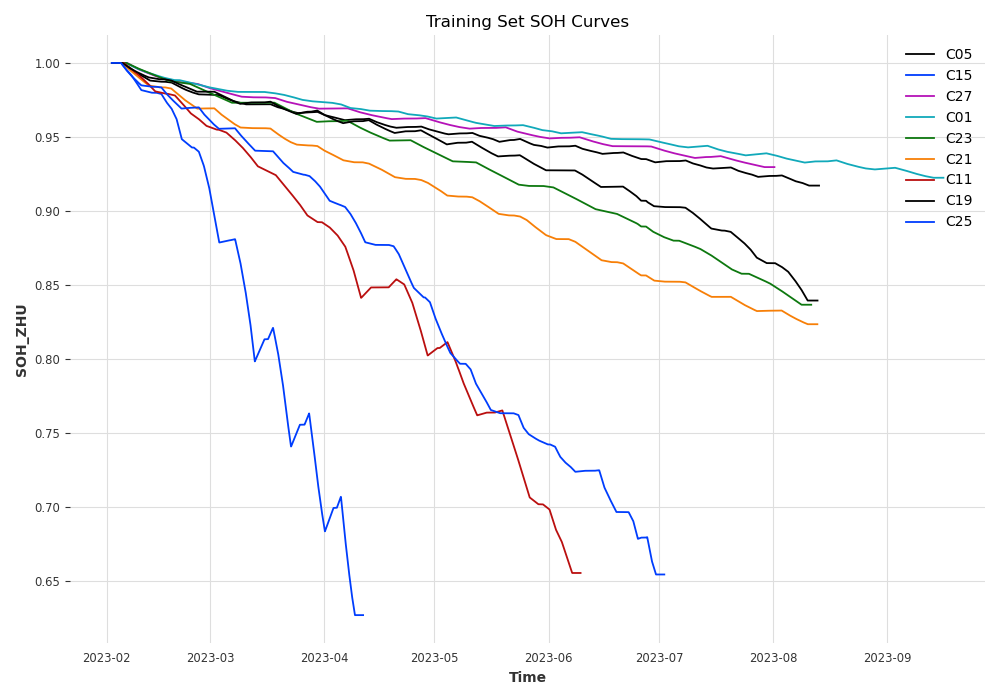

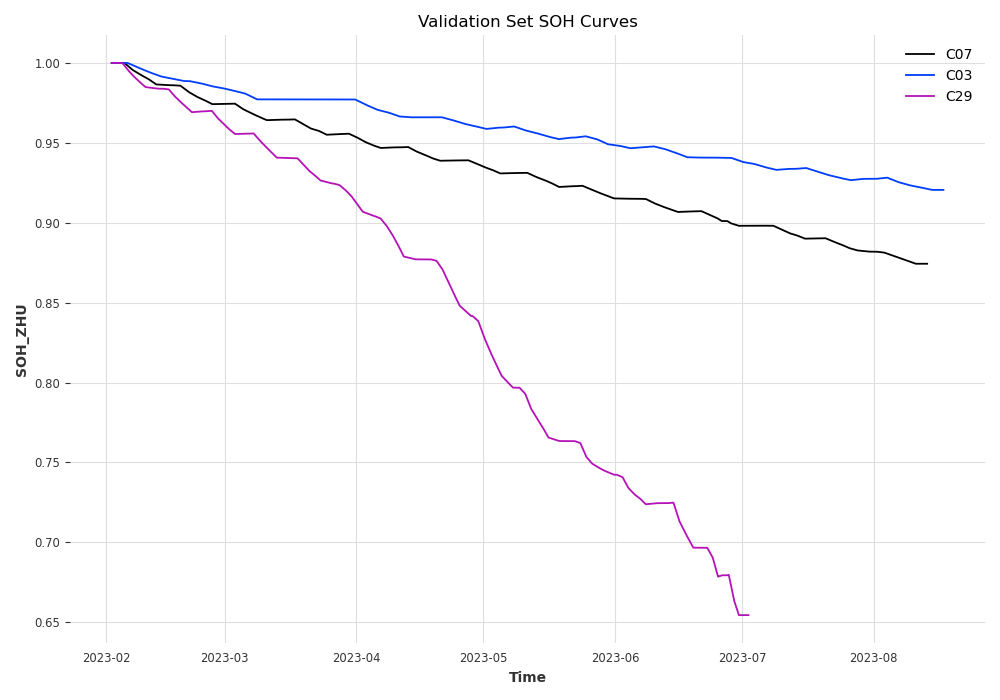

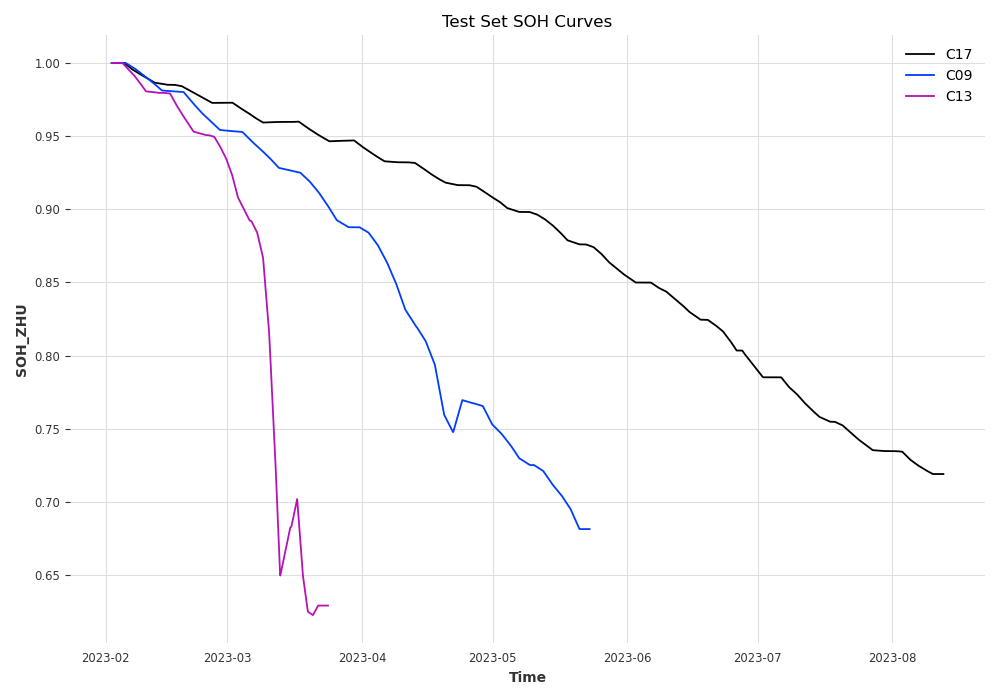

In [38]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_dataset_soh(data_dict: dict, title: str, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    
    # Plot each cell's SOH
    for cell_name, cell_data in data_dict.items():
        target = cell_data['target']
        plt.plot(target.time_index, target.values().flatten(), label=cell_name)
    
    plt.title(f'{title} Set SOH Curves')
    plt.xlabel('Time')
    plt.ylabel('SOH_ZHU')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Plot all three datasets
%matplotlib widget
plot_dataset_soh(train_data, "Training")
plot_dataset_soh(val_data, "Validation")
plot_dataset_soh(test_data, "Test")

In [ ]:
def prepare_data(train_data, val_data):
    # Concatenate training data
    train_targets = []
    train_covariates = []
    for cell_data in train_data.values():
        train_targets.append(cell_data['target'])
        train_covariates.append(cell_data['covariates_scaled'])
    
    train_series = train_targets[0]
    train_cov = train_covariates[0]
    for i in range(1, len(train_targets)):
        train_series = train_series.concatenate(train_targets[i])
        train_cov = train_cov.concatenate(train_covariates[i])
    
    # Concatenate validation data
    val_targets = []
    val_covariates = []
    for cell_data in val_data.values():
        val_targets.append(cell_data['target'])
        val_covariates.append(cell_data['covariates_scaled'])
    
    val_series = val_targets[0]
    val_cov = val_covariates[0]
    for i in range(1, len(val_targets)):
        val_series = val_series.concatenate(val_targets[i])
        val_cov = val_cov.concatenate(val_covariates[i])
    
    return train_series, train_cov, val_series, val_cov